In [7]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
path = '../Images_suspects/'
path_orig = '../Original_images_suspects/'

In [2]:
# ROTATION
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

# TRANSLATION
def random_translation(image, max_shift_x, max_shift_y):

    # Dimensions de l'image
    height, width = image.shape[:2]

    # Génération de décalages aléatoires
    shift_x = np.random.randint(-max_shift_x, max_shift_x)
    shift_y = np.random.randint(-max_shift_y, max_shift_y)

    # Matrice de translation
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Application de la translation
    translated_image = cv2.warpAffine(image, translation_matrix, (width, height))

    return translated_image

def translation(image, shift_x, shift_y):

    # Dimensions de l'image
    height, width = image.shape[:2]

    # Matrice de translation
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Application de la translation
    translated_image = cv2.warpAffine(image, translation_matrix, (width, height))

    return translated_image

In [3]:
# Backgrounds

def create_diagonal_gradient_image(width, height):
    # Initialisation de l'image avec des zéros
    image = np.zeros((height, width), dtype=np.float32)
    
    # Calcul de la valeur du dégradé pour chaque pixel
    for y in range(height):
        for x in range(width):
            # Normalisation des coordonnées
            nx = x / (width - 1)
            ny = y / (height - 1)
            # Calcul de la valeur en niveaux de gris basée sur la distance diagonale
            value = (nx + ny) / 2.0
            image[y, x] = value
    
    # Conversion en niveaux de gris de 0 à 255
    image = (image * 255).astype(np.uint8)
    return image

def create_nonlinear_diagonal_gradient_image(width, height, power=2):
    # Initialisation de l'image avec des zéros
    image = np.zeros((height, width), dtype=np.float32)
    
    # Calcul de la valeur du dégradé pour chaque pixel
    for y in range(height):
        for x in range(width):
            # Normalisation des coordonnées
            nx = x / (width - 1)
            ny = y / (height - 1)
            # Calcul de la valeur en niveaux de gris avec une progression non linéaire
            value = ((nx + ny) / 2.0) ** power
            image[y, x] = value
    
    # Conversion en niveaux de gris de 0 à 255
    image = (image * 255).astype(np.uint8)
    return image

def create_diagonal_gradient_image(width, height, angle_degrees, nonlinear_function=np.sin):
    # Initialisation de l'image avec des zéros
    image = np.zeros((height, width), dtype=np.float32)
    
    # Conversion de l'angle en radians
    angle_radians = np.deg2rad(angle_degrees)
    
    # Calcul des composantes de direction
    cos_a = np.cos(angle_radians)
    sin_a = np.sin(angle_radians)
    
    # Calcul de la valeur du dégradé pour chaque pixel
    for y in range(height):
        for x in range(width):
            # Projection de la position du pixel sur la direction du dégradé
            projection = (x * cos_a + y * sin_a)
            # Normalisation de la projection
            normalized_projection = projection / (width * cos_a + height * sin_a)
            # Application de la fonction non linéaire
            value = nonlinear_function(normalized_projection * np.pi)
            # Normalisation de la valeur
            value = (value + 1) / 2.0  # Pour s'assurer que les valeurs sont entre 0 et 1
            image[y, x] = value
    
    # Conversion en niveaux de gris de 0 à 255
    image = (image * 255).astype(np.uint8)
    return image

In [4]:
# Bruits
def add_gaussian_noise(image, mean=0, stddev=25):
    noise = np.random.normal(mean, stddev, image.shape).astype(np.float64)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def add_uniform_noise(image, low=-50, high=50):
    noise = np.random.uniform(low, high, image.shape).astype(image.dtype)
    noisy_image = cv2.add(image, noise)
    return noisy_image

In [5]:
# Image 1
# Fond pas uniforme, empreinte visible minus relatif
#  
img = ~cv2.imread(path_orig+'1.tif',0)
rot_img = rotate_image(img,np.random.randint(-60,60))
trans_img = random_translation(rot_img,50,50)
erod_img = cv2.morphologyEx(trans_img,cv2.MORPH_ERODE,cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
mask = erod_img>0

background = create_nonlinear_diagonal_gradient_image(388,388,1)
output = background
output[mask] = output[mask]-30
plt.imshow(background,'gray',vmin=0,vmax=255)
cv2.imwrite(path+'suspect_1.tif',output)

TypeError: bad operand type for unary ~: 'NoneType'

True

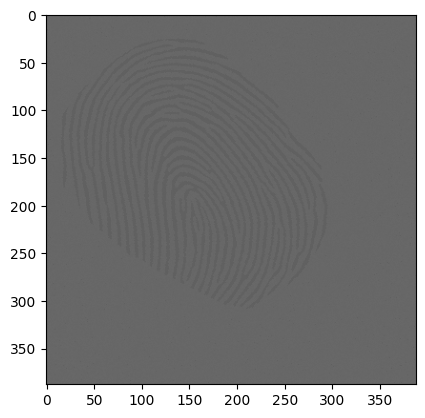

In [8]:
# Image 2
# Fond uniforme, très peu de contraste, et du sel poivre autour de l'empreinte
img = ~cv2.imread(path_orig+'2.tif',0)
rot_img = rotate_image(img,np.random.randint(-60,60))
trans_img = random_translation(rot_img,50,50)
erod_img = cv2.morphologyEx(trans_img,cv2.MORPH_ERODE,cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
mask = erod_img>0

contours,__ = cv2.findContours(erod_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
convexHull = cv2.convexHull(np.concatenate(list(contours),axis=0))
mask_convex = ~cv2.drawContours(np.zeros_like(erod_img),[convexHull],-1,(255,0,0),-1)
mask_convex = cv2.erode(mask_convex,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15)))

noise_pepper_mask = np.logical_and((np.random.randint(0,1000,(388,388))<5),mask_convex>0)

background = np.ones((388,388),dtype=np.uint8)*100
output = background
offset_mask = np.random.randint(2,5,(388,388))
minus_mask = np.logical_or(mask,noise_pepper_mask)
output[minus_mask] = output[minus_mask]-offset_mask[minus_mask]
output[~minus_mask] = output[~minus_mask]+offset_mask[~minus_mask]


plt.imshow(output,'gray',vmin=0,vmax=255)
cv2.imwrite(path+'suspect_2.tif',output)

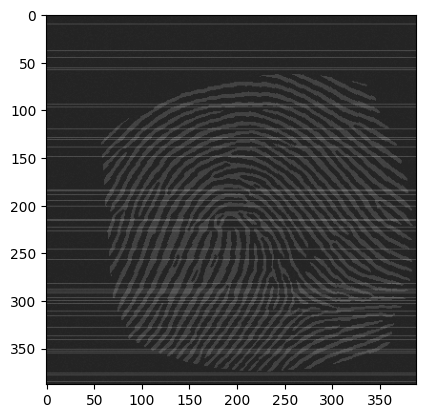

In [112]:
# Image 3
# Fond à peu près uniforme, 
img = ~cv2.imread(path_orig+'3.tif',0)
rot_img = rotate_image(img,np.random.randint(-10,10))
trans_img = translation(rot_img,50,0)
erod_img = cv2.morphologyEx(trans_img,cv2.MORPH_ERODE,cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)))
mask = erod_img>0

background = np.ones((388,388),dtype=np.uint8)*30
offset_mask = np.random.randint(5,10,(388,388),dtype=np.uint8)
background+=offset_mask
output = background
output[mask] = output[mask]+30

# Ajout random de lignes éclairées
random_lines = np.random.randint(0,100,(388)) < 10

output[random_lines,:] = output[random_lines,:]+40

plt.imshow(output,'gray',vmin=0,vmax=255)
plt.show()

cv2.imwrite(path+'suspect_3.tif',output)

True

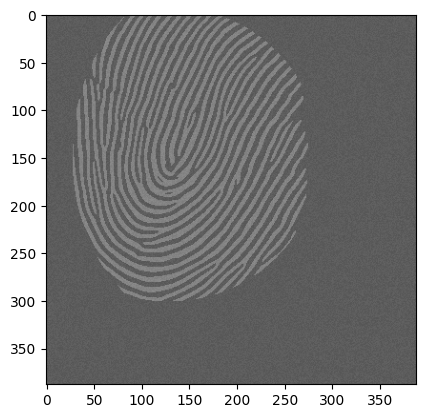

In [93]:
# Image 4
# Fond à peu près uniforme, 
import random

img = ~cv2.imread(path_orig+'4.tif',0)
rot_img = rotate_image(img,180)
trans_img = translation(rot_img,-50,-30)
mask = trans_img>0

background = np.ones((388,388),dtype=np.uint8)*80
offset_mask = np.random.randint(5,20,(388,388),dtype=np.uint8)
background+=offset_mask

output = background.copy()
output[mask] = output[mask] + 40
plt.imshow(output,'gray',vmin=0,vmax=255)

cv2.imwrite(path+'suspect_4.tif',output)

True

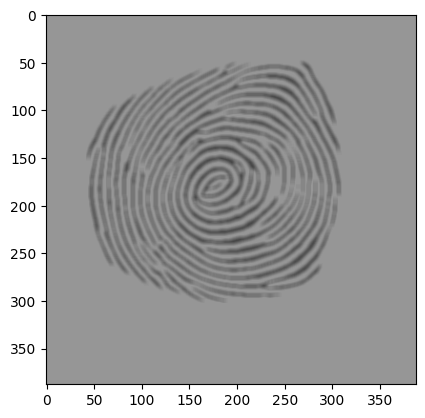

In [12]:
# Image 5
import random

img = ~cv2.imread(path_orig+'5.tif',0)
rot_img = rotate_image(img,90)
trans_img = random_translation(rot_img,50,50)
erod_img = cv2.morphologyEx(trans_img,cv2.MORPH_ERODE,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
mask = erod_img>0

background = np.ones((388,388),dtype=np.uint8)*150

output = background.copy()
output[mask] = output[mask] - 80

output = cv2.blur(output,(5,5))

plt.imshow(output,'gray',vmin=0,vmax=255)

cv2.imwrite(path+'suspect_5.tif',output)